In [16]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = pd.read_csv('manufacturer_data.csv', sep=';', decimal=',')

df['T_sup_HP'] = df['T_sup_HP'] + 273
df['T_OA'] = df['T_OA'] + 273
df['Q_HP_real'] = df['Q_HP_real']*1000

df['cold'] = np.where(df['T_OA'] <= 273-15, 1, 0)

# Get the position of NaN values and remove the rows
df = df.replace('NaN', np.nan)
NaN_index = np.where(df['COP_real'].isna())[0]
df = df.dropna().reset_index()
df_regression = df[df['T_OA']<= 273-15]

df_regression

,index,T_OA,T_sup_HP,COP_real,Q_HP_real,W_HP,m_HP,cold
0,0,248,303,2.08,9250.0,4.45,0.67,1
1,1,253,303,2.26,10630.0,4.70,0.67,1
2,2,258,303,2.45,12000.0,4.90,0.67,1
12,12,248,303,1.80,9000.0,5.00,0.67,1
13,13,253,308,2.05,10500.0,5.12,0.67,1
14,14,258,308,2.30,12000.0,5.22,0.67,1
24,24,248,313,1.53,8750.0,5.72,0.67,1
25,25,253,313,1.84,10380.0,5.64,0.67,1
26,26,258,313,2.15,12000.0,5.58,0.67,1
36,36,248,318,1.25,8500.0,6.80,0.67,1


# Predicting COP with a linear model

In [17]:
# Declare the model
mod = smf.ols(formula='Q_HP_real ~ T_OA', data=df_regression)

# Fit the model (finds the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2) 
res = mod.fit()

# Print the summary output
# print(res.summary())

In [18]:
print(res.params)

Intercept   -68851.589041
T_OA           313.315068
dtype: float64


In [19]:
def cop(outT):
    return res.params.Intercept + res.params.T_OA*outT

# Get all the predicted COPs in a list
COP_list = []
for i in range(len(df['T_OA'])):
    if df['cold'][i]==1: COP_list.append(round(cop(df['T_OA'][i]),2))
    else: COP_list.append(14000)

# Get a list of all the real COPs
COP_list_real = list(df.Q_HP_real)

# Compare with the real COPs
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(COP_list_real, COP_list)
print("MSE = {}".format(round(mse,3)))
print("sqrt(MSE) = {}".format(round(np.sqrt(mse),3)))

MSE = 5586.247
sqrt(MSE) = 74.741


In [20]:
#print(round(cop(293, 284.81),2))
#print(COP_list)

In [21]:
df = pd.read_csv('manufacturer_data.csv', sep=';', decimal=',')
df['COP_pred'] = 0
df['Q_HP_real'] = df['Q_HP_real']*1000

j = 0
for i in range(len(df.COP_real)):    
    if i in NaN_index:
        df['COP_pred'].iloc[i] = np.nan
    else:
        df['COP_pred'].iloc[i] = COP_list[j]
        j = j+1
        
df = df.fillna(0)

/Users/thomasdefauw/miniconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


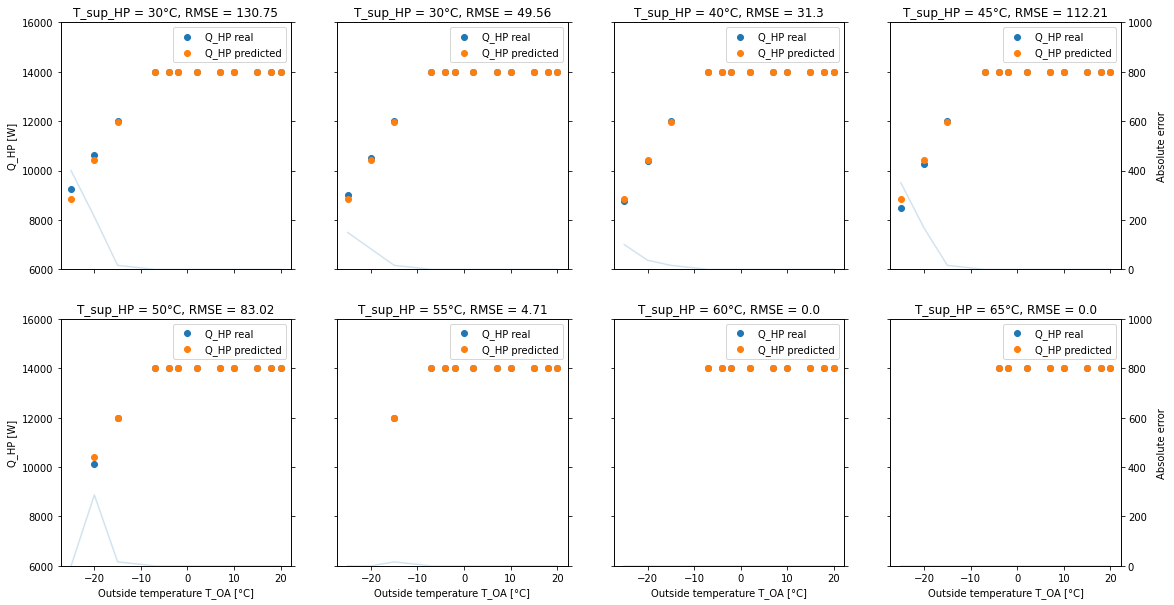

In [22]:
 # Creating a 2x4 (2 height, 4 width) grid of plots
fig, ax = plt.subplots(2,4, figsize=(19,10), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):
        
        # This is the trick: i*width + j
        k = i*4 + j
        begin = k*12
        end = (k+1)*12
        
        mse_k = mean_squared_error(df.Q_HP_real[begin:end], df.COP_pred[begin:end])

        ax[i,j].scatter(df.T_OA[begin:end], df.Q_HP_real[begin:end], label="Q_HP real")
        ax[i,j].scatter(df.T_OA[begin:end], df.COP_pred[begin:end], label="Q_HP predicted")

        ax2 = ax[i, j].twinx()
        ax2.plot(df.T_OA[begin:end], abs(df.Q_HP_real[begin:end] - df.COP_pred[begin:end]), alpha=0.2)
        if j==3: ax2.set_ylabel("Absolute error")
        ax2.set_ylim(0,1000)
        if j!=3:
            ax2.set_yticklabels([])
    
        
        ax[i,j].set_title("T_sup_HP = {}°C, RMSE = {}".format(df.T_sup_HP[begin], round(np.sqrt(mse_k),2)))
        if i==1: ax[i,j].set_xlabel("Outside temperature T_OA [°C]")
        if j==0: ax[i,j].set_ylabel("Q_HP [W]")
        ax[i,j].legend()
        ax[i,j].set_ylim(6000,16000)
        
plt.savefig('results/regression_Q_HP.jpg', dpi=300)
plt.show()